OpenStax Data Extraction
===

Prealgebra: https://openstax.org/books/prealgebra-2e/pages/1-introduction

Algebra 1: https://openstax.org/details/books/elementary-algebra-2e

In [2]:
import re
import time
from pathlib import Path

import bs4
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import tiktoken
from tqdm import tqdm

In [3]:
data = requests.get("https://openstax.org/books/prealgebra-2e/pages/1-introduction")

In [4]:
html_doc = data.content.decode()
html_doc[:50]

'<!doctype html><html lang="en" prefix="og: http://'

In [5]:
soup = bs4.BeautifulSoup(html_doc, "html.parser")

In [6]:
with open("doc.html", "w") as outfile:
    outfile.write(soup.prettify())

In [8]:
with open("doc.html") as infile:
    contents = infile.read()
soup = bs4.BeautifulSoup(contents, "html.parser")

In [9]:
soup.find_all("summary")[0].find_all("a")

[]

In [10]:
toc = soup.find_all(attrs={"class": "os-text"})
len(toc)

172

In [280]:
# toc[3].parent.parent.parent.parent.parent.parent.find_all(attrs={"class": "os-text"})

In [8]:
toc_links = toc[3].parent.parent.parent.parent.parent.parent.find_all("a")
len(toc_links)

131

In [9]:
for link in toc_links:
    print(link.text)

Preface
Introduction
1.1 Introduction to Whole Numbers
1.2 Add Whole Numbers
1.3 Subtract Whole Numbers
1.4 Multiply Whole Numbers
1.5 Divide Whole Numbers
Key Terms
Key Concepts
Review Exercises
Practice Test
Introduction to the Language of Algebra
2.1 Use the Language of Algebra
2.2 Evaluate, Simplify, and Translate Expressions
2.3 Solving Equations Using the Subtraction and Addition Properties of Equality
2.4 Find Multiples and Factors
2.5 Prime Factorization and the Least Common Multiple
Key Terms
Key Concepts
Review Exercises
Practice Test
Introduction to Integers
3.1 Introduction to Integers
3.2 Add Integers
3.3 Subtract Integers
3.4 Multiply and Divide Integers
3.5 Solve Equations Using Integers; The Division Property of Equality
Key Terms
Key Concepts
Review Exercises
Practice Test
Introduction to Fractions
4.1 Visualize Fractions
4.2 Multiply and Divide Fractions
4.3 Multiply and Divide Mixed Numbers and Complex Fractions
4.4 Add and Subtract Fractions with Common Denominators

In [10]:
textbook_data = []
root_url = "https://openstax.org/books/prealgebra-2e/pages/"
for link in toc_links:
    # print(f"{link.text} {link['href']}")
    title = link.text
    href = link["href"]
    url_tokens = href.split("-")
    try:
        chapter = int(url_tokens[0])
    except:
        continue
    try:
        section = int(url_tokens[1])
    except:
        section = 0
    if section == 0:
        for expected_section_name in ["key-terms", "key-concepts", "review-exercises", "practice-test"]:
            if href.endswith(expected_section_name):
                section = expected_section_name.replace("-", "_")
    if section == 0:
        continue
    # print(f"ch{chapter} {section} {href}")
    textbook_data.append(
        {
            "chapter": chapter,
            "section": section,
            "href": href,
        }
    )

In [11]:
root_url + href

'https://openstax.org/books/prealgebra-2e/pages/index'

In [12]:
for d in tqdm(textbook_data):
    if "soup" not in d or True:
        data = requests.get(root_url + d["href"])
        html_doc = data.content.decode()
        soup = bs4.BeautifulSoup(html_doc, "html.parser")
        d["soup"] = soup
        time.sleep(0.5)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [01:32<00:00,  1.13it/s]


In [13]:
textbook_data[3]["soup"].text[:2000]

'1.4 Multiply Whole Numbers - Prealgebra 2e | OpenStaxSkip to ContentGo to accessibility pageKeyboard shortcuts menuPrealgebra 2e1.4 Multiply Whole NumbersPrealgebra 2e1.4 Multiply Whole NumbersCloseMenuContentsContentsHighlightsPrintTable of contentsPreface1\n \nWhole NumbersIntroduction1.1 Introduction to Whole Numbers1.2 Add Whole Numbers1.3 Subtract Whole Numbers1.4 Multiply Whole Numbers1.5 Divide Whole NumbersChapter ReviewKey TermsKey ConceptsExercisesReview ExercisesPractice Test2\n \nThe Language of AlgebraIntroduction to the Language of Algebra2.1 Use the Language of Algebra2.2 Evaluate, Simplify, and Translate Expressions2.3 Solving Equations Using the Subtraction and Addition Properties of Equality2.4 Find Multiples and Factors2.5 Prime Factorization and the Least Common MultipleChapter ReviewKey TermsKey ConceptsExercisesReview ExercisesPractice Test3\n \nIntegersIntroduction to Integers3.1 Introduction to Integers3.2 Add Integers3.3 Subtract Integers3.4 Multiply and Divid

In [14]:
soup.find(attrs={"tabindex": "0"}).find_all("section")[0]

<section class="practice-test" data-depth="1" id="fs-id1725312">
<div class="os-hasSolution" data-type="exercise" id="fs-id1725320"><header></header><section><div data-type="problem" id="fs-id1725322">
<a class="os-number" data-page-fragment="fs-id1725320-solution" data-page-slug="chapter-11" data-page-uuid="7e9d17a8-9ebd-54ce-a2ba-04b836eaeef0" href="chapter-11">339</a><span class="os-divider">. </span>
<div class="os-problem-container">
<p id="fs-id1725324">Plot and label these points:</p>
<ol class="circled" id="eip-id1164752955290" type="1"><li><span class="token">ⓐ</span> <math display="inline"><semantics><mrow><mspace width="0.2em"></mspace><mo>(</mo><mn>2</mn><mo>,</mo><mn>5</mn><mo>)</mo></mrow><annotation-xml encoding="MathML-Content"><mspace width="0.2em"></mspace><mo>(</mo><mn>2</mn><mo>,</mo><mn>5</mn><mo>)</mo></annotation-xml></semantics></math></li>
<li><span class="token">ⓑ</span> <math display="inline"><semantics><mrow><mrow><mspace width="0.2em"></mspace><mrow><mo>(</

In [49]:
def parse_section(section):
    header_tags = ["title", "h1", "h2", "h3", "h4", "h5"]
    content_tags = [None, "strong", "em", "b", "li", "span", "a", "sup", "u"]
    if section.has_attr("class") and "section-exercises" in section["class"]:
        return
    section_title = ""
    section_content = ""
    n_replacements = 0
    n_tables = 0
    n_images = 0
    # replace math with text representation
    # (this avoids a problem with duplicating math spans)
    for math_span in section.find_all("math"):
        math_span.replace_with(math_span.find("annotation-xml").text)
        n_replacements += 1
    # replace images
    for img in section.find_all("img"):
        # img.replace_with("Figure: " + img["alt"])
        # TODO could also include the figure number and caption without much difficulty, if desired
        img.replace_with("")
        n_replacements += 1
        n_images += 1
    subsubsections = []
    for tag in section.contents:
        text_content = None
        if tag.name == "section":
            subsubsections.append(parse_section(tag))
            continue
        if tag.name in header_tags:
            tag_text = tag.text.strip()
            section_title += tag_text + " "
            # if tag_text.endswith("Exercises") or tag_text == "Practice Makes Perfect":
            #    break
        elif tag.name == "div":
            if tag.has_attr("data-type"):
                assert tag["data-type"] in ["note", "example", "equation"], tag
                # currently dropping this text, could save it
            elif tag.table is not None:
                n_tables += 1
                # text_content = tag.table["aria-label"]
            else:
                assert tag.figure is not None, tag
        elif type(tag) == bs4.NavigableString:
            text_content = tag.string
        else:
            assert len(tag.contents) == 1 or all(
                [child.name in content_tags for child in tag.children]
            ), f"{[child.name for child in tag.children if child.name not in content_tags]} {tag}"
            text_content = tag.text
        if text_content is not None:
            section_content += text_content + "\n"
    section_title = section_title.strip()
    section_content = re.sub(r"\n(\n)+", "\n\n", section_content.strip())
    return {
        "title": section_title,
        "content": section_content,
        "subsections": subsubsections,
    }


def parse_textbook_soup(soup):
    page = soup.find(attrs={"tabindex": "0"})
    suptitle = soup.find("h1").text
    assert len(page.contents) == 1
    sections = []
    for i, section in enumerate(page.find_all("section", attrs={"data-depth": "1"})):
        parsed = parse_section(section)
        if parsed:
            parsed["index"] = i
            sections.append(parsed)
    return sections, suptitle

In [50]:
for chapter in textbook_data:
    if chapter["section"] == 0 or type(chapter["section"]) == str:
        continue
    subsections, suptitle = parse_textbook_soup(chapter["soup"])
    chapter["subsections"] = subsections
    chapter["title_text"] = suptitle
    print(f"s{chapter['chapter']}.{chapter['section']} {len(subsections)} {suptitle}")

s1.1 6 1.1 Introduction to Whole Numbers
s1.2 5 1.2 Add Whole Numbers
s1.3 5 1.3 Subtract Whole Numbers
s1.4 5 1.4 Multiply Whole Numbers
s1.5 5 1.5 Divide Whole Numbers
s2.1 4 2.1 Use the Language of Algebra
s2.2 4 2.2 Evaluate, Simplify, and Translate Expressions
s2.3 6 2.3 Solving Equations Using the Subtraction and Addition Properties of Equality
s2.4 4 2.4 Find Multiples and Factors
s2.5 2 2.5 Prime Factorization and the Least Common Multiple
s3.1 5 3.1 Introduction to Integers
s3.2 5 3.2 Add Integers
s3.3 5 3.3 Subtract Integers
s3.4 5 3.4 Multiply and Divide Integers
s3.5 5 3.5 Solve Equations Using Integers; The Division Property of Equality
s4.1 7 4.1 Visualize Fractions
s4.2 4 4.2 Multiply and Divide Fractions
s4.3 4 4.3 Multiply and Divide Mixed Numbers and Complex Fractions
s4.4 4 4.4 Add and Subtract Fractions with Common Denominators
s4.5 6 4.5 Add and Subtract Fractions with Different Denominators
s4.6 5 4.6 Add and Subtract Mixed Numbers
s4.7 4 4.7 Solve Equations with 

In [51]:
tokeniser = tiktoken.encoding_for_model("gpt-3.5-turbo-0613")

In [52]:
def add_subsection_sizes(subsections):
    for subsection in subsections:
        title, content = subsection["title"], subsection["content"]
        content = title + content
        n_tokens = len(tokeniser.encode(content))
        subsection["n_tokens"] = n_tokens
        add_subsection_sizes(subsection["subsections"])


add_subsection_sizes(textbook_data[-5]["subsections"])

In [53]:
def print_subsection_sizes(subsections, depth=0):
    for subsection in subsections:
        print(f"{' '*depth} {subsection['n_tokens']:>4} {subsection['title']}")
        print_subsection_sizes(subsection["subsections"], depth=depth + 5)


for chapter_section in textbook_data:
    if "subsections" not in chapter_section:
        continue
    add_subsection_sizes(chapter_section["subsections"])
    print_subsection_sizes(chapter_section["subsections"])

  287 Identify Counting Numbers and Whole Numbers
  224 Model Whole Numbers
  295 Identify the Place Value of a Digit
  147 Use Place Value to Name Whole Numbers
   23 Use Place Value to Write Whole Numbers
  545 Round Whole Numbers
  120 Use Addition Notation
  147 Model Addition of Whole Numbers
  413 Add Whole Numbers Without Models
   53 Translate Word Phrases to Math Notation
  147 Add Whole Numbers in Applications
   97 Use Subtraction Notation
   63 Model Subtraction of Whole Numbers
  171 Subtract Whole Numbers
   60 Translate Word Phrases to Math Notation
   81 Subtract Whole Numbers in Applications
  138 Use Multiplication Notation
   60 Model Multiplication of Whole Numbers
  521 Multiply Whole Numbers
   50 Translate Word Phrases to Math Notation
  265 Multiply Whole Numbers in Applications
  270 Use Division Notation
   49 Model Division of Whole Numbers
  611 Divide Whole Numbers
   48 Translate Word Phrases to Math Notation
   71 Divide Whole Numbers in Applications
  76

In [54]:
def get_subsection_total(subsections):
    total = 0
    for subsection in subsections:
        total += subsection["n_tokens"]
        total += get_subsection_total(subsection["subsections"])
    return total


get_subsection_total(textbook_data[-5]["subsections"])

1660

In [55]:
def get_subsection_sizes(subsections):
    sizes = []
    for subsection in subsections:
        sizes.append(subsection["n_tokens"])
        sizes.extend(get_subsection_sizes(subsection["subsections"]))
    return sizes


sizes = []
section_totals = []
for chapter_section in textbook_data:
    if "subsections" not in chapter_section:
        continue
    sizes.extend(get_subsection_sizes(chapter_section["subsections"]))
    section_totals.append(get_subsection_total(chapter_section["subsections"]))
len(sizes), len(section_totals)

(280, 60)

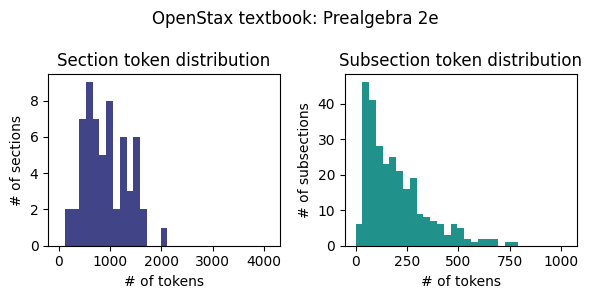

In [56]:
fig, axes = plt.subplots(1, 2, figsize=(6, 3))

ax = axes[1]
bins = np.linspace(0, 4096 // 4, num=4096 // 4 // 32)
ax.hist(sizes, bins=bins, color=matplotlib.cm.viridis(0.5))
ax.set_title("Subsection token distribution")
ax.set_ylabel("# of subsections")
ax.set_xlabel("# of tokens")

ax = axes[0]
bins = np.linspace(0, 4096, num=4096 // 4 // 32)
ax.hist(section_totals, bins=bins, color=matplotlib.cm.viridis(0.2))
ax.set_title("Section token distribution")
ax.set_ylabel("# of sections")
ax.set_xlabel("# of tokens")

fig.suptitle("OpenStax textbook: Prealgebra 2e")
fig.tight_layout()
fig.savefig("../figures/openstax_prealgebra_token_hist.png", dpi=190)
plt.show()

### Save parsed OpenStax data

In [66]:
# subsection-level
ds = []
for chapter_section in textbook_data:
    if "subsections" not in chapter_section:
        continue
    for subsection in chapter_section["subsections"]:
        subsection = subsection.copy()
        if "subsections" in subsection and subsection["subsections"] != []:
            for subsubsection in subsection["subsections"]:
                subsection["content"] += subsubsection["title"] + ":\n" + subsubsection["content"]
        del subsection["subsections"]
        subsection["chapter"] = chapter_section["chapter"]
        subsection["section"] = chapter_section["section"]
        ds.append(subsection)
len(ds)

247

In [67]:
openstax_subsection_df = pd.DataFrame(ds)
openstax_subsection_df.shape

(247, 6)

In [68]:
openstax_subsection_df.sample(n=3)

,title,content,index,n_tokens,chapter,section
229,Plot Points on a Rectangular Coordinate System,"Many maps, such as the Campus Map shown in Fig...",0,754,11,1
148,Use the Definition of Proportion,In the section on Ratios and Rates we saw some...,0,317,6,5
90,Find the Least Common Denominator,"In the previous section, we explained how to a...",0,631,4,5


In [69]:
openstax_subsection_df.section.value_counts()

section
1    50
3    44
4    44
2    41
5    40
6    17
7    11
Name: count, dtype: int64

In [73]:
data_dir = Path("../data")
assert data_dir.exists()

In [75]:
derived_openstax_dir = data_dir / "derived" / "openstax"
derived_openstax_dir.mkdir(exist_ok=True)

In [78]:
openstax_subsection_df.to_parquet(derived_openstax_dir / "openstax_prealgebra_subsection_df.parquet")